In [1]:
# prepares the notebook for "inline" graphing, and imports matplotlib library
%matplotlib inline
%config InlineBackend.figure_format='svg'
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
basePath = r'C:\Users\Ted Mburu\NbO2'
fileName = r'IVNb0p95Ti0p05O2_24-05162022-10.txt'

def find_between(s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""

NbPercentage = str(int(find_between(fileName, "IVNb", "Ti").split('p')[1]) / 100)
TiPercentage = str(int(find_between(fileName, "Ti", "O2").split('p')[1]) / 100)
sampleNumber = find_between(fileName, "_", "-")
deviceNumber = find_between(fileName, "-", ".txt").split('-')[1]

filePath = ''
if (NbPercentage  == "0.95"):
    filePath = basePath + r'\Doping05\ '.rstrip() + fileName
elif (NbPercentage  == "0.90"):
    filePath = basePath + r'\Doping10\ '.rstrip() + fileName
else: 
    filePath = basePath + r'\Doping0\ '.rstrip() + fileName
    
df5 = pd.read_csv(filePath, names=['Time (s)','Current (A)','Voltage (V)'],sep='\t',skiprows=1)
data=df5.values
df5.head()

t= data[:,0]
I= data[:,1]
V= data[:,2]

print(filePath)

C:\Users\Ted Mburu\NbO2\Doping05\IVNb0p95Ti0p05O2_24-05162022-10.txt


All Data


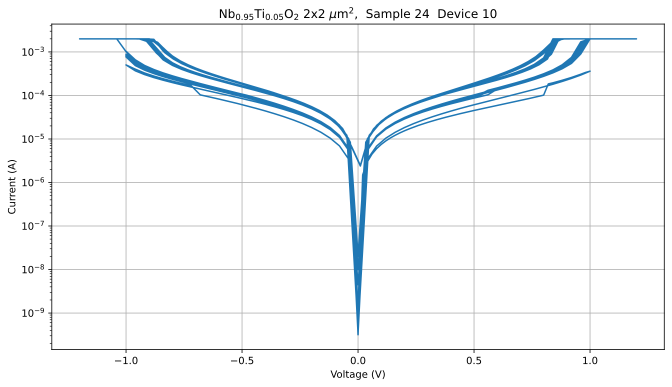

In [3]:
plt.rcParams['figure.figsize'] = (11,6)
plt.figure(0)
plt.grid()
plt.semilogy(V,I)

plt.xlabel('Voltage (V)');
plt.ylabel('Current (A)');

nb = 'Nb' if NbPercentage == "1.0" else r'Nb$_{'+ NbPercentage +'}$'
ti = '' if TiPercentage == "0.0" else r'Ti$_{'+ TiPercentage +'}$'
sampleText = '  Sample ' + sampleNumber
device = '  Device ' + deviceNumber

title = nb + ti + r'O$_2$ 2x2 $\mu$m$^2$,' + sampleText + device
plt.title(title);
print("All Data")

In [4]:
largestCurrent = np.amax(I)
maxCurrentThreshhold = largestCurrent * 0.80;
indexOfFirstLargeCurrent = np.argmax(I > maxCurrentThreshhold)

t= t[indexOfFirstLargeCurrent:]
I= I[indexOfFirstLargeCurrent:]
V= V[indexOfFirstLargeCurrent:]

secondDerivativeCurrent = np.gradient(np.gradient(I))

# manually calc slopes 

In [5]:
allZeroIndexes = []
zeroIndexes = []

allMaxIndexes = []
maxIndexes = []

posThreshValues = []
negThreshValues = []
posHoldValues = []
negHoldValues = []

In [6]:
def isIncreasing(L):
    return L[0] < L[len(L) - 1]

def isDecreasing(L):
    return L[0] > L[len(L) - 1]

def non_increasing(L):
    return all(x>=y for x, y in zip(L, L[1:]))

def non_decreasing(L):
    return all(x<=y for x, y in zip(L, L[1:]))

def monotonic(L):
    return non_increasing(L) or non_decreasing(L)

# 0 to + is thresh
# + to 0 is hold
# 0 to - thresh on neg
# - to 0 hold on neg

# this will sort runs into the piles and make all the currents positive

def sortIntoSide(time, voltage, current, secondDerivative):
    if isIncreasing(voltage) and isIncreasing(current):
        current = [ abs(x) for x in current]
        posThreshValues.append([time, voltage, current, secondDerivative])
    elif isDecreasing(voltage) and isDecreasing(current):
        current = [ abs(x) for x in current]
        posHoldValues.append([time, voltage, current, secondDerivative])
    elif isDecreasing(voltage) and isIncreasing(current):
        current = [ abs(x) for x in current]
        negThreshValues.append([time, voltage, current, secondDerivative])
    elif isIncreasing(voltage) and isDecreasing(current):
        current = [ abs(x) for x in current]
        negHoldValues.append([time, voltage, current, secondDerivative])
    else: 
        print("???")

In [7]:
# indexes of values that are pretty much 0
zeroThreshhold = 1e-5
for index, x in enumerate(I):
    if x < zeroThreshhold:
        allZeroIndexes.append(index)

# find the zero values that begin or end a run
zeroIndexes.append(allZeroIndexes[0])
for x in range(len(allZeroIndexes) - 1):
    if allZeroIndexes[x]+1 != allZeroIndexes[x+1]:
        zeroIndexes.append(allZeroIndexes[x])
        zeroIndexes.append(allZeroIndexes[x+1])

In [8]:
# find all the values that hit the max
for index, x in enumerate(I):
    if x > maxCurrentThreshhold:
        allMaxIndexes.append(index)
        
print(allMaxIndexes[:50])

# find the max values that start or end a run
for x in range(len(allMaxIndexes) - 1):
    if allMaxIndexes[x]+1 != allMaxIndexes[x+1]:
        maxIndexes.append(allMaxIndexes[x])
        maxIndexes.append(allMaxIndexes[x+1])

newMaxIndexes = []

for x in range(len(allMaxIndexes) - 1):
    if allMaxIndexes[x]+1 != allMaxIndexes[x+1]:
        newMaxIndexes.append(allMaxIndexes[x]+1)
        newMaxIndexes.append(allMaxIndexes[x+1]+1)

[0, 99, 100, 200, 300, 400, 499, 500, 600, 700, 800, 899, 900, 1000, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157]


In [9]:
# combine all zero and max indexes into one sorted array
allIndexes = [*zeroIndexes, *maxIndexes]
allIndexes = sorted(allIndexes)

for x in range(3, len(allIndexes) - 1, 4):
    allIndexes[x] = allIndexes[x] + 1
    
goodRuns = []
for x in range(0, len(allIndexes) - 4, 4):
    if monotonic( V[allIndexes[x]:allIndexes[x+3]] ):
        goodRuns.append(allIndexes[x])
        goodRuns.append(allIndexes[x+1])
        goodRuns.append(allIndexes[x+2])
        goodRuns.append(allIndexes[x+3])
    
allIndexes = np.copy(goodRuns)
# print("all", allIndexes[:50])
# print()
# print("max", maxIndexes[:50])
# print()
# print("new", newMaxIndexes[:50])


In [10]:
# loop through each run and put the V and I values into an array
# then make an array with all the arrays
# the indexes in the original current array is also passed
timesToLoop = len(zeroIndexes) - 1
# timesToLoop = 20
for x in range(0, timesToLoop, 2):
    voltageRun = []
    currentRun = []
    timeRun = []
    secondDerivativeRun = []
    start = allIndexes[x]
    stop = allIndexes[x+1]
    for y in range(start, stop):
        voltageRun.append(V[y])
        currentRun.append(I[y])
        timeRun.append(t[y])
        secondDerivativeRun.append(I[y])

    sortIntoSide(timeRun, voltageRun, currentRun, np.gradient(np.gradient(currentRun)))

In [11]:
# take second derivative of each current array

posThreshValuesGradients = []
negThreshValuesGradients = []
posHoldValuesGradients = []
negHoldValuesGradients = []

for x in posThreshValues:
    posThreshValuesGradients.append(x[3])
for x in negThreshValues:
    negThreshValuesGradients.append(x[3])
for x in posHoldValues:
    posHoldValuesGradients.append(x[3])
for x in negHoldValues:
    negHoldValuesGradients.append(x[3])
    
# find the index of the largest value in the 2nd derivative
posThreshValuesLargestGradient = []
negThreshValuesLargestGradient = []
posHoldValuesLargestGradient = []
negHoldValuesLargestGradient = []

# 0 to + is thresh
# + to 0 is hold
# 0 to - thresh on neg
# - to 0 hold on neg

# for x in posThreshValuesGradients:
#     largestValue = np.argmax(np.absolute(x[1:len(x) - 1])) - 1
#     posThreshValuesLargestGradient.append(largestValue)
# for x in negThreshValuesGradients:
#     largestValue = np.argmax(np.absolute(x[1:len(x) - 1])) - 1
#     negThreshValuesLargestGradient.append(largestValue)
# for x in posHoldValuesGradients:
#     largestValue = np.argmax(np.absolute(x[1:len(x) - 1])) + 1
#     posHoldValuesLargestGradient.append(largestValue)
# for x in negHoldValuesGradients:
#     largestValue = np.argmax(np.absolute(x[1:len(x) - 1])) + 1
#     negHoldValuesLargestGradient.append(largestValue)
    
for x in posThreshValuesGradients:
    largestValue = np.argmax(np.absolute(x[1:len(x) - 1])) + 1
    posThreshValuesLargestGradient.append(largestValue)
for x in negThreshValuesGradients:
    largestValue = np.argmax(np.absolute(x[1:len(x) - 1])) + 1
    negThreshValuesLargestGradient.append(largestValue)
for x in posHoldValuesGradients:
    largestValue = np.argmax(np.absolute(x[1:len(x) - 1])) + 1
    posHoldValuesLargestGradient.append(largestValue)
for x in negHoldValuesGradients:
    largestValue = np.argmax(np.absolute(x[1:len(x) - 1])) + 1
    negHoldValuesLargestGradient.append(largestValue)

In [12]:
# get the voltage when the largest second derivative happens
posThreshValuesVoltage = []
negThreshValuesVoltage = []
posHoldValuesVoltage = []
negHoldValuesVoltage = []

for x in range(len(posThreshValuesGradients)):
    voltage = posThreshValues[x][1][posThreshValuesLargestGradient[x]]
    posThreshValuesVoltage.append(voltage)
for x in range(len(negThreshValuesGradients)):
    voltage = negThreshValues[x][1][negThreshValuesLargestGradient[x]]
    negThreshValuesVoltage.append(voltage)
for x in range(len(posHoldValuesGradients)):
    voltage = posHoldValues[x][1][posHoldValuesLargestGradient[x]]
    posHoldValuesVoltage.append(voltage)
for x in range(len(negHoldValuesGradients)):
    voltage = negHoldValues[x][1][negHoldValuesLargestGradient[x]]
    negHoldValuesVoltage.append(voltage)

print(posThreshValuesVoltage)
print(negThreshValuesVoltage)
print(posHoldValuesVoltage)
print(negHoldValuesVoltage)

[0.816, 0.816, 0.8, 0.8, 0.8, 0.8, 0.81665, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.83335, 0.83335, 0.83335, 0.83335]
[-1.0, -0.816, -0.816, -0.8, -0.84, -0.8, -0.8, -0.83335, -0.83335, -0.83335, -0.83335, -0.83335, -0.83335, -0.8, -0.83335, -0.8, -0.83335, -0.83335, -0.8, -0.83335, -0.8, -0.8, -0.8, -0.8, -0.8]
[0.92, 0.768, 0.768, 0.8, 0.76, 0.8, 0.8, 0.78, 0.8, 0.76665, 0.76665, 0.76665, 0.76665, 0.8, 0.76665, 0.8, 0.76665, 0.76665, 0.8, 0.76665, 0.8, 0.76665, 0.76665, 0.8, 0.76665]
[-0.864, -0.864, -0.84, -0.88, -0.84, -0.84, -0.87, -0.86665, -0.86665, -0.86665, -0.86665, -0.83335, -0.83335, -0.86665, -0.83335, -0.86665, -0.83335, -0.83335, -0.86665, -0.83335, -0.86665, -0.86665, -0.86665, -0.86665]


In [13]:
posThreshValuesCurrent = []
negThreshValuesCurrent = []
posHoldValuesCurrent = []
negHoldValuesCurrent = []

for x in range(len(posThreshValuesGradients)):
    current = posThreshValues[x][2][posThreshValuesLargestGradient[x]]
    posThreshValuesCurrent.append(current)
for x in range(len(negThreshValuesGradients)):
    current = negThreshValues[x][2][negThreshValuesLargestGradient[x]]
    negThreshValuesCurrent.append(current)
for x in range(len(posHoldValuesGradients)):
    current = posHoldValues[x][2][posHoldValuesLargestGradient[x]]
    posHoldValuesCurrent.append(current)
for x in range(len(negHoldValuesGradients)):
    current = negHoldValues[x][2][negHoldValuesLargestGradient[x]]
    negHoldValuesCurrent.append(current)

In [14]:
def average(array):
    return sum(array) / len(array)

print("Positive Threshold Voltage: ", average(posThreshValuesVoltage), "Standard Deviation: ", np.std(posThreshValuesVoltage))
print("Negative Threshold Voltage: ", average(negThreshValuesVoltage), "Standard Deviation: ", np.std(negThreshValuesVoltage))
print("Positive Hold Voltage: ", average(posHoldValuesVoltage), "Standard Deviation: ", np.std(posHoldValuesVoltage))
print("Negative Hold Voltage: ", average(negHoldValuesVoltage), "Standard Deviation: ", np.std(negHoldValuesVoltage))

Positive Threshold Voltage:  0.8075854166666668 Standard Deviation:  0.012677387013618197
Negative Threshold Voltage:  -0.8242200000000001 Standard Deviation:  0.039277991292834706
Positive Hold Voltage:  0.7851659999999999 Standard Deviation:  0.031737207564623574
Negative Hold Voltage:  -0.8554687499999999 Standard Deviation:  0.015794261962418506


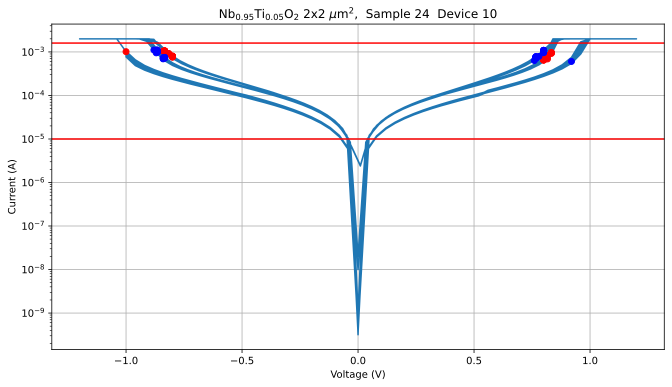

In [15]:
    plt.rcParams['figure.figsize'] = (11,6)
    plt.figure(0)
    plt.grid()
    plt.semilogy(V, I)
    plt.xlabel('Voltage (V)');
    plt.ylabel('Current (A)');
    nb = 'Nb' if NbPercentage == "1.0" else r'Nb$_{'+ NbPercentage +'}$'
    ti = '' if TiPercentage == "0.0" else r'Ti$_{'+ TiPercentage +'}$'
    sampleText = '  Sample ' + sampleNumber
    device = '  Device ' + deviceNumber

    title = nb + ti + r'O$_2$ 2x2 $\mu$m$^2$,' + sampleText + device
    
    plt.axhline(y=maxCurrentThreshhold, color='r', linestyle='-')
    plt.axhline(y=zeroThreshhold, color='r', linestyle='-')

#     voltage = average(posThreshValuesVoltage)
#     current = average(posThreshValuesCurrent)
#     plt.errorbar(voltage, current, xerr=np.std(posThreshValuesVoltage), fmt="ro")

#     voltage = average(negThreshValuesVoltage)
#     current = average(negThreshValuesCurrent)
#     plt.errorbar(voltage, current, xerr=np.std(negThreshValuesVoltage), fmt="bo")

#     voltage = average(posHoldValuesVoltage)
#     current = average(posHoldValuesCurrent)
#     plt.errorbar(voltage, current, xerr=np.std(posHoldValuesVoltage), fmt="go")

#     voltage = average(negHoldValuesVoltage)
#     current = average(negHoldValuesCurrent)
#     plt.errorbar(voltage, current, xerr=np.std(negHoldValuesVoltage), fmt="yo")
    
    for y in range(len([*posThreshValuesVoltage, *negThreshValuesVoltage]) - 1):
        voltage = [*posThreshValuesVoltage, *negThreshValuesVoltage]
        current = [*posThreshValuesCurrent, *negThreshValuesCurrent]
        plt.errorbar(voltage[y], current[y], xerr=0, fmt="ro")
        
    for y in range(len([*posHoldValuesVoltage, *negHoldValuesVoltage]) - 1):
        voltage = [*posHoldValuesVoltage, *negHoldValuesVoltage]
        current = [*posHoldValuesCurrent, *negHoldValuesCurrent]
        plt.errorbar(voltage[y], current[y], xerr=0, fmt="bo")

    plt.title(title);

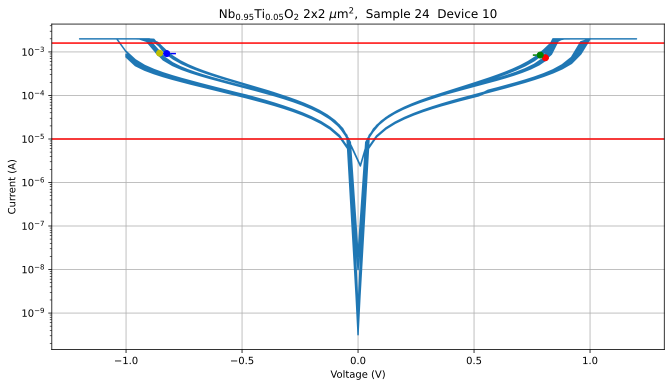

In [16]:
    plt.rcParams['figure.figsize'] = (11,6)
    plt.figure(0)
    plt.grid()
    plt.semilogy(V, I)
    plt.xlabel('Voltage (V)');
    plt.ylabel('Current (A)');
#     nb = 'Nb' if NbPercentage == "1.0" else r'Nb$_{'+ NbPercentage +'}$'
#     ti = '' if TiPercentage == "0.0" else r'Ti$_{'+ TiPercentage +'}$'
#     sampleText = '  Sample ' + sampleNumber
#     device = '  Device ' + deviceNumber

#     title = nb + ti + r'O$_2$ 2x2 $\mu$m$^2$,' + sampleText + device
    
    plt.axhline(y=maxCurrentThreshhold, color='r', linestyle='-')
    plt.axhline(y=zeroThreshhold, color='r', linestyle='-')

    voltage = average(posThreshValuesVoltage)
    current = average(posThreshValuesCurrent)
    plt.errorbar(voltage, current, xerr=np.std(posThreshValuesVoltage), fmt="ro")

    voltage = average(negThreshValuesVoltage)
    current = average(negThreshValuesCurrent)
    plt.errorbar(voltage, current, xerr=np.std(negThreshValuesVoltage), fmt="bo")

    voltage = average(posHoldValuesVoltage)
    current = average(posHoldValuesCurrent)
    plt.errorbar(voltage, current, xerr=np.std(posHoldValuesVoltage), fmt="go")

    voltage = average(negHoldValuesVoltage)
    current = average(negHoldValuesCurrent)
    plt.errorbar(voltage, current, xerr=np.std(negHoldValuesVoltage), fmt="yo")
    
#     for y in range(len([*posThreshValuesVoltage, *negThreshValuesVoltage]) - 1):
#         voltage = [*posThreshValuesVoltage, *negThreshValuesVoltage]
#         current = [*posThreshValuesCurrent, *negThreshValuesCurrent]
#         plt.errorbar(voltage[y], current[y], xerr=0, fmt="ro")
        
#     for y in range(len([*posHoldValuesVoltage, *negHoldValuesVoltage]) - 1):
#         voltage = [*posHoldValuesVoltage, *negHoldValuesVoltage]
#         current = [*posHoldValuesCurrent, *negHoldValuesCurrent]
#         plt.errorbar(voltage[y], current[y], xerr=0, fmt="bo")

    plt.title(title);

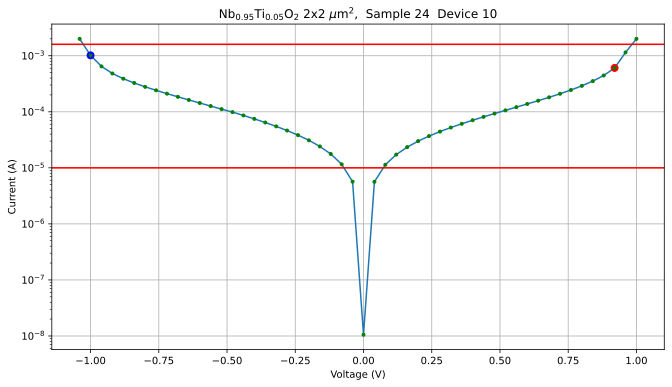

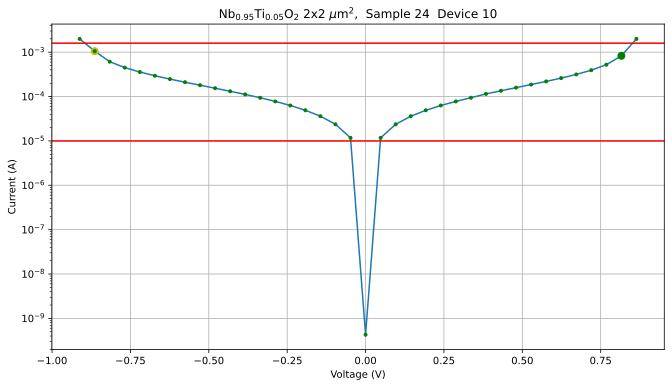

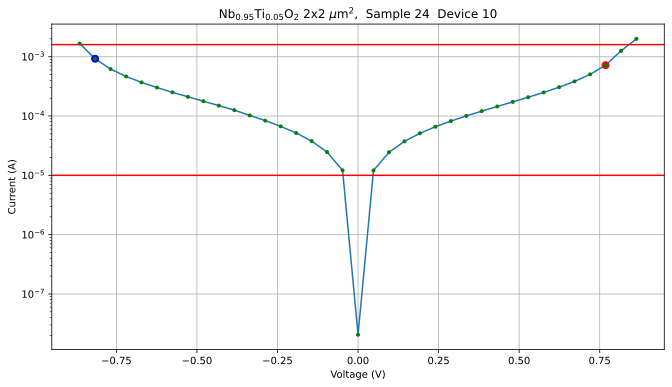

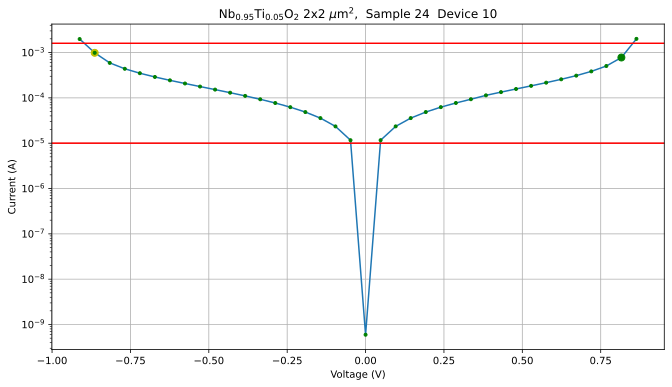

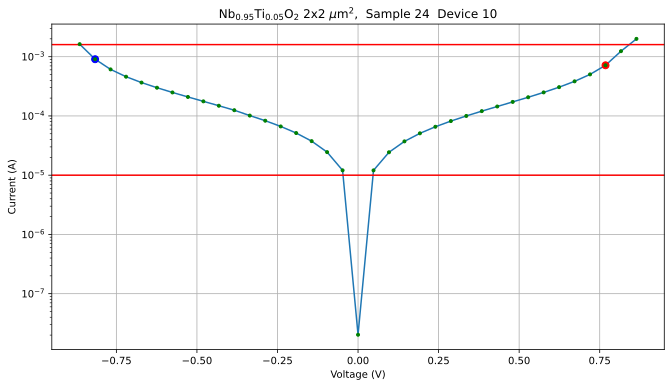

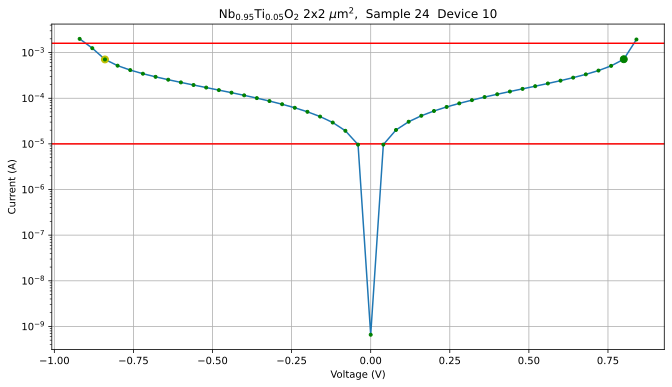

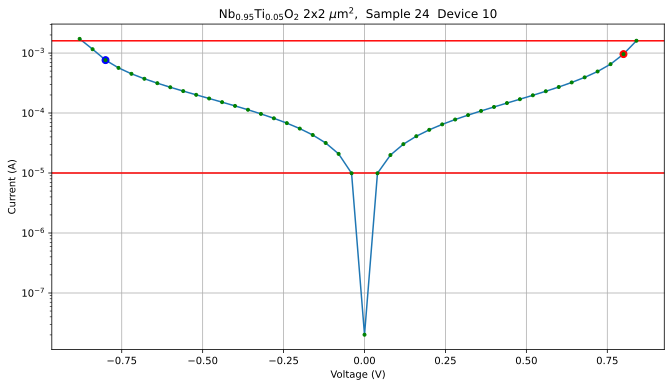

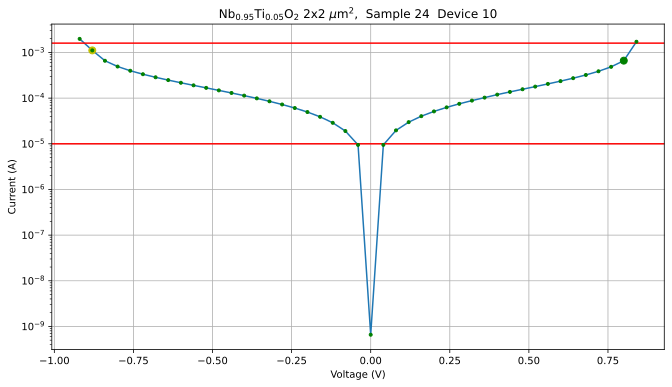

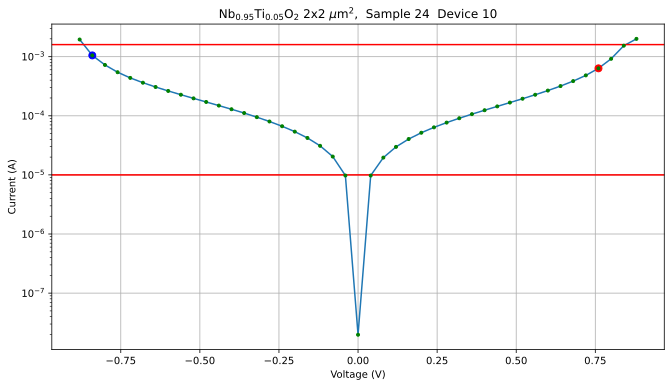

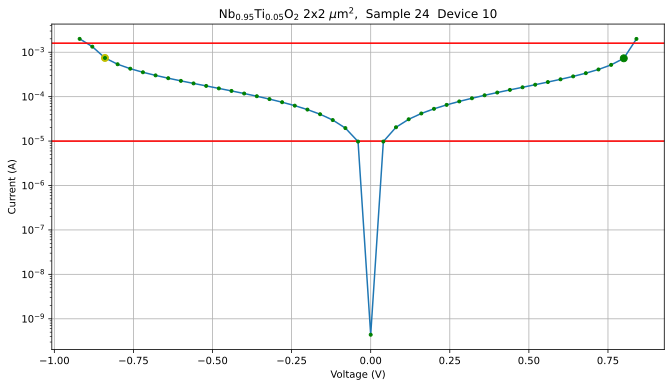

In [17]:
for x in range(0, 40, 4):
    plt.rcParams['figure.figsize'] = (11,6)
    plt.figure(x)
    plt.grid()
    plt.semilogy(V[allIndexes[x]:allIndexes[x+3]], I[allIndexes[x]:allIndexes[x+3]])
#     plt.semilogy(V[allIndexes[x]:allIndexes[x+3]], secondDerivativeCurrent[allIndexes[x]:allIndexes[x+3]])
#     plt.semilogy(V[allIndexes[x]:allIndexes[x+3]], secondDerivativeCurrent[allIndexes[x]:allIndexes[x+3]])
    plt.xlabel('Voltage (V)');
    plt.ylabel('Current (A)');
    
    plt.axhline(y=maxCurrentThreshhold, color='r', linestyle='-')
    plt.axhline(y=zeroThreshhold, color='r', linestyle='-')
    
#     yellow - neg hold
#     green - pos hold
#     blue - neg thresh
#     red - pos thresh

# for x in posThreshValues:
#     posThreshValuesGradients.append(x[3])
# for x in negThreshValues:
#     negThreshValuesGradients.append(x[3])
# for x in posHoldValues:
#     posHoldValuesGradients.append(x[3])
# for x in negHoldValues:
#     negHoldValuesGradients.append(x[3])
    
    for y in posThreshValuesCurrent:
        if y in I[allIndexes[x]:allIndexes[x+3]]:
            index = list(I).index(y)
            plt.errorbar(V[index], I[index], xerr=0, fmt="go", markersize=7)
            
    for y in negThreshValuesCurrent:
        if y in I[allIndexes[x]:allIndexes[x+3]]:
            index = list(I).index(y)
            plt.errorbar(V[index], I[index], xerr=0, fmt="bo", markersize=7)
    
    for y in posHoldValuesCurrent:
        if y in I[allIndexes[x]:allIndexes[x+3]]:
            index = list(I).index(y)
            plt.errorbar(V[index], I[index], xerr=0, fmt="ro", markersize=7)
            
    for y in negHoldValuesCurrent:
        if y in I[allIndexes[x]:allIndexes[x+3]]:
            index = list(I).index(y)
            plt.errorbar(V[index], I[index], xerr=0, fmt="yo", markersize=7)
    
    for a in range(allIndexes[x],allIndexes[x+3]):
        plt.errorbar(V[a], I[a], xerr=0, fmt="go", markersize=3)

    plt.title(title);

In [18]:
    # voltage = average(posThreshValuesVoltage)
    # current = average(posThreshValuesCurrent)
    # plt.errorbar(voltage, current, xerr=np.std(posThreshValuesVoltage), fmt="ro")

    # voltage = average(negThreshValuesVoltage)
    # current = average(negThreshValuesCurrent)
    # plt.errorbar(voltage, current, xerr=np.std(posThreshValuesVoltage), fmt="bo")

    # voltage = average(posHoldValuesVoltage)
    # current = average(posHoldValuesCurrent)
    # plt.errorbar(voltage, current, xerr=np.std(posThreshValuesVoltage), fmt="go")

    # voltage = average(negHoldValuesVoltage)
    # current = average(negHoldValuesCurrent)
    # plt.errorbar(voltage, current, xerr=np.std(posThreshValuesVoltage), fmt="yo")